# Data Description:
#### A short (non medically exhaustive) description of the feature meaning

**analysis of umbilical artery blood sample**
- **pH** : Is the ph of the blood of the baby (n.v. 7.35-7.45). A slight increase causes blood alkalosis while a slight decrease causes acidosis. Both conditions are extremely life threatening. This value is inverse proportional to **pCO2**.
- **BDecf** : Base excess of extracellular fluid is a quantity that reflects only the non-respiratory (metabolic) component of acid-base disturbances. (Reference : [Here](https://acutecaretesting.org/en/articles/all-about-base-excess--to-be-or-not-to-be))
- **pCO2** : is the relative pressure of CO2 in the blood (n.v. 4.5-6.0Kpa). In Respiratory Acidosis, **pH** and **pCO2** are inverse proportional while in Metabolic Acidosis they are directly proportional.
- **BE** : is the excess or deficit (if negative) of bases in the blood (e.g. HCO3). The normal range is between -2 and +2 mEq/L or mmol/L. A value above the range is indicative of Metabolic Alkalosis while below the range is indicative of Metabolic Acidosis.

- **Apgar1** : It's the Apgar score at 1min from birth. It indicates the overall health status of the baby at birth. It can have values between 0 and 10 where a score above 7 is considered good. (Reference and table : [Here](https://www.birthinjurysafety.org/birth-injuries/apgar-scoring-system.html))
- **Apgar5** : It's the Apgar score at 5min from birth. See **Apgar1**.
- **Gest. weeks** : It's the number of weeks of gestation where 39-40 weeks represent a normal term delivery.
- **Weight(g)** : Is the weigth of the baby in grams at birth. This is various but in general the normal range would be between 2500g and 4500g.
- **Sex** : This is a boolean for 1 and 2 where is not clear which is male/female but shouldn't matter.
- **Age** : The Age in years of the mom.
- **Gravidity** : Is the number of times the woman has been pregnant in her life.
- **Parity** : Is the number of times the woman has been pregnant for more than 24 weeks (in a single pregnancy).
- **Diabetes** : Boolean value for Diabetes of 0 (False) and 1 (True).
- **Hypertension** : Boolean value for Hypertension of 0 (False) and 1 (True).
- **Preeclampsia** : Boolean value for Preeclampsia of 0 (False) and 1 (True). where Preeclampsia indicate a disorder of pregnancy that could lead to complications.
- **Liq.** : It referes to Liquor which in this case is the Amniotic Fluid. <mark>I'm not sure why is a boolean in the data.</mark>
- **Pyrexia** : Is a boolean value that indicate the presence of pyrexia (high temperature) in the mom or not.
- **Meconium** : Is a boolean value that indicate the presence or not of Meconium which is the earliest stool of the baby that could happen before partum.
- **Presentation** : <mark>This indicate the presentation of the baby during delivery which can be head first, legs first etc. The problem here is that this value is a number which most probably refers to an internal classification or a scale I don't know how to interpret. **See also Deliv. type**</mark>
- **Induced** : Is a boolean value that indicate if the delivery has been medically induced.
- **I.stage** : <mark>It should indicate the time in between contractions in the stage of the delivery but this is only my observational opinon based on the data.</mark>
- **NoProgress** : Is a boolean value that indicate if there has been an abort of the pregnancy or not.
- **CK/KP** : <mark>It should refer to the level of Creatine Kinase?</mark>
- **II.stage** : <mark>see **I.stage**.</mark>
- **Deliv. type** : <mark>(1: vaginal; 2: operative vaginal; 3: CS)</mark>
- **dbID** : is just an ID of the record
- **Rec. type** : <mark>No idea</mark>
- **Pos. II.st.** : <mark>No idea</mark>

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class CTG_data:
    
    df = pd.DataFrame()
    
    # Initialize dataframe, converts floats to integer where possible,
    # Optimise datatype (e.g. from Float64 to Float16) where possible
    # Drop columns that contains only unique values
    # Store nan values and unique values as:
    #     self.nan_values and self.unique_values
    # Store the name of the features that contains nan values in a list:
    #     self.contains_nan
    def __init__(self,*signal):
        if signal:
            df_signal = pd.read_csv("database/signals/%s" % signal) 
            df_signal = df_signal.set_index("seconds")
            df_signal.index.rename("",inplace=True)
            self.df = df_signal
            self.floats_to_integers()
            self.optimize_datatypes()
        else:
            df_ann = pd.read_csv("database/ann_db.csv")
            df_ann = df_ann.set_index('Unnamed: 0')
            df_ann.index.rename('', inplace=True)
            df_ann = df_ann.T
            self.df = df_ann
            self.floats_to_integers()
            self.optimize_datatypes()
            self.drop_unique_columns()
            self.get_nan_values()
            self.get_unique_values_numbers()
    
    def get_nan_values(self):
        df = self.df
        self.nan_values = {"TOTAL_RECORDS" : df.shape[0]}
        self.contains_nan = []
        for col in tqdm(df.columns):
            self.nan_values[col] = df[col].loc[df[col].isna() == True].size
            if self.nan_values[col] > 0:
                self.contains_nan.append(col)

    def get_unique_values_numbers(self):
        df = self.df
        self.unique_dict = {}
        for col in tqdm(df.columns):
            col_dict = {}
            unique_values = df[col].unique()
            nan_values = df[col].loc[df[col].isna() == True].size
            if nan_values > 0:
                col_dict["nan"] = nan_values
            for val in unique_values:
                col_dict[val] = df[col].loc[df[col] == val].shape[0]
            self.unique_dict[col] = col_dict

    def floats_to_integers(self):
        df = self.df
        for col in df.columns:
            if df[col].dtype == "float64" or df[col].dtype == "float32":
                isint = df[col].apply(lambda x : x.is_integer())
                if False not in np.array(isint):
                    df[col] = df[col].astype("int64")
        self.df = df

    def optimize_datatypes(self):
        df = self.df
        for col in df.columns:
            if df[col].dtype == "float64":
                df[col] = df[col].astype("float32")
            elif df[col].dtype == "int64":
                maxvalue = df[col].max()
                minvalue = df[col].min()
                if (minvalue >= -128 and maxvalue <= 127) or (minvalue >= 0 and maxvalue <= 255):
                    df[col] = df[col].astype("int8")
                else:
                    df[col] = df[col].astype("int16")
        self.df = df

    def drop_unique_columns(self):
        df = self.df
        unique_values = {}
        for col in tqdm(df.columns):
            unique_values[col] = df[col].unique().size
            if unique_values[col] < 2:
                df = df.drop([col],axis=1)
        self.df = df

    def convert_nan_values(self):
        df = self.df
        for col in tqdm(self.contains_nan):
            isint = df[col].apply(lambda x : x.is_integer())
            isint = isint.loc[isint == False].index
            uniques_values = df[col].loc[df[col].index.isin(isint)].unique()
            if uniques_values.size < 2 :
                if str(uniques_values[0]) == "nan":
                    df[col].fillna(value=np.around(df[col].mean()),inplace=True)
            else:
                df[col].fillna(value=df[col].mean(),inplace=True)

        self.df = df


In [3]:
# Get CTG Annotations data
ctg_data = CTG_data()
ctg_data.df.head()

100%|██████████| 28/28 [00:00<00:00, 57.67it/s]


,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight(g),Sex,Age,...,Presentation,Induced,I.stage,NoProgress,CK/KP,II.stage,Deliv. type,dbID,Rec. type,Pos. II.st.
1220,7.30,3.52,6.0,-4.7,9,10,42,3100.0,2,34,...,1.0,1,165,0,0,15,1,3056,2,14400
1234,7.29,2.50,6.5,-4.2,8,9,41,3200.0,1,29,...,1.0,0,135,0,0,10,1,5619,1,14400
1208,7.23,5.84,6.6,-7.4,9,9,40,3900.0,2,26,...,1.0,0,260,0,0,30,1,960,12,14400
1038,7.33,2.72,5.7,-4.0,10,10,39,2740.0,1,24,...,2.0,0,15,0,0,10,1,19468,1,14400
1004,7.30,5.19,5.5,-6.4,8,9,41,3370.0,1,36,...,1.0,1,55,0,0,10,1,237,12,14400


In [4]:
ctg_data.df.describe().T

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
pH,552.0,7.230055,0.105039,6.850000,7.17,7.25,7.30,7.470000
BDecf,541.0,4.601905,3.553392,-3.400000,2.49,4.13,6.14,26.110001
pCO2,541.0,7.069500,1.556687,0.700000,5.90,7.00,7.90,12.300000
BE,541.0,-6.384105,3.827454,-26.799999,-8.00,-5.60,-4.00,-0.200000
Apgar1,552.0,8.262681,1.624959,1.000000,8.00,9.00,9.00,10.000000
Apgar5,552.0,9.068841,1.085613,4.000000,9.00,9.00,10.00,10.000000
Gest. weeks,552.0,39.994565,1.132737,37.000000,39.00,40.00,41.00,43.000000
Weight(g),551.0,3400.426514,454.781921,1970.000000,3100.00,3410.00,3700.00,4750.000000
Sex,552.0,1.481884,0.500125,1.000000,1.00,1.00,2.00,2.000000


We can notice that:

- there are few NaN values in the dataset;
- the number of decimal points for some of the features (e.g. weight) is too high which means that is not been converted appropriately from float to int. This may be due to the presence of null values. We'll tackle that later.

In [5]:
print(ctg_data.nan_values)

{'TOTAL_RECORDS': 552, 'pH': 0, 'BDecf': 11, 'pCO2': 11, 'BE': 11, 'Apgar1': 0, 'Apgar5': 0, 'Gest. weeks': 0, 'Weight(g)': 1, 'Sex': 0, 'Age': 0, 'Gravidity': 4, 'Parity': 0, 'Diabetes': 0, 'Hypertension': 0, 'Preeclampsia': 0, 'Liq.': 0, 'Pyrexia': 0, 'Meconium': 0, 'Presentation': 3, 'Induced': 0, 'I.stage': 0, 'NoProgress': 0, 'CK/KP': 0, 'II.stage': 0, 'Deliv. type': 0, 'dbID': 0, 'Rec. type': 0, 'Pos. II.st.': 0}


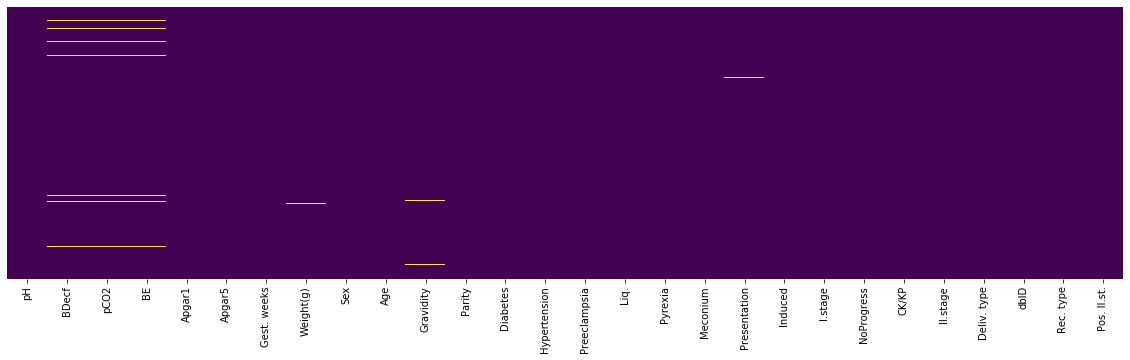

In [6]:
plt.figure(figsize=(20, 5))
sns.heatmap(ctg_data.df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are very few NaN values, BDecf, pCO2 and BE have NaN values for the same records which means that for those babies the some blood test wasn't available. The total number of null values is 41 over 552 which is 7.4% of NaN values over the total.

there are few strategies we can follow to get rid of the NaN values:

1. <mark>replace NaN with mean value for the column;</mark>
2. delete the entire tuple with NaN values (7.4% or 41 tuples);
3. replace NaN with a custom values.

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Let's display now the unique values for each of the annotation features to see what is the distribution of the data and if the data are effectively skewed or balanced and for what features.

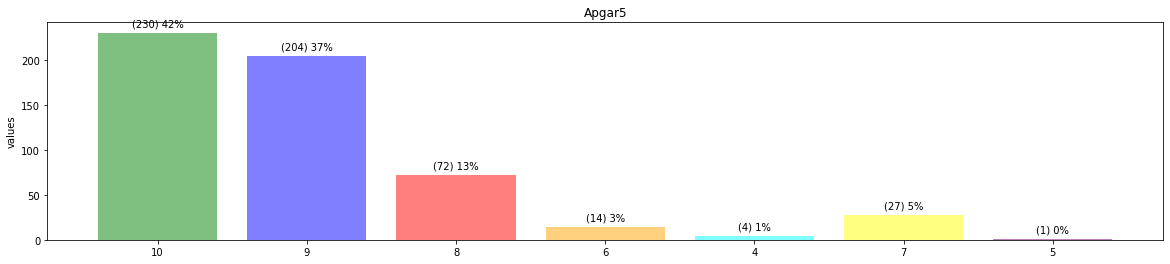

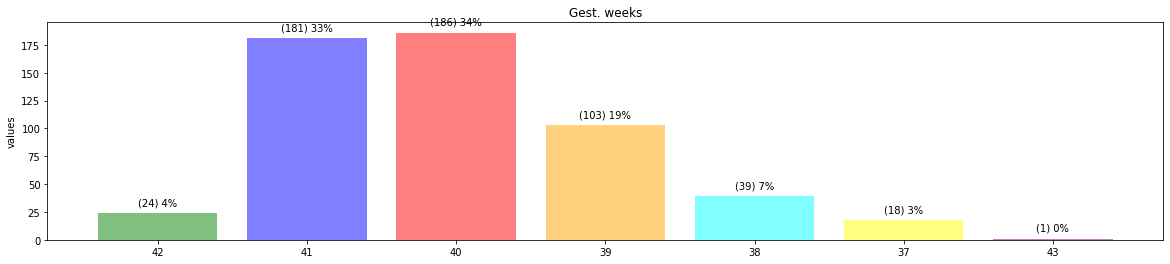

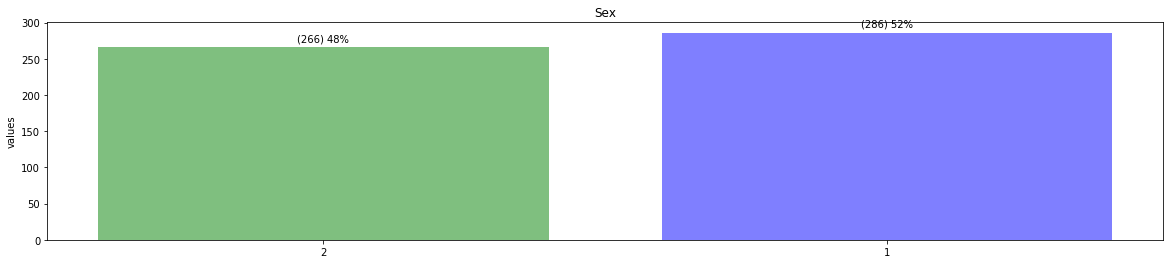

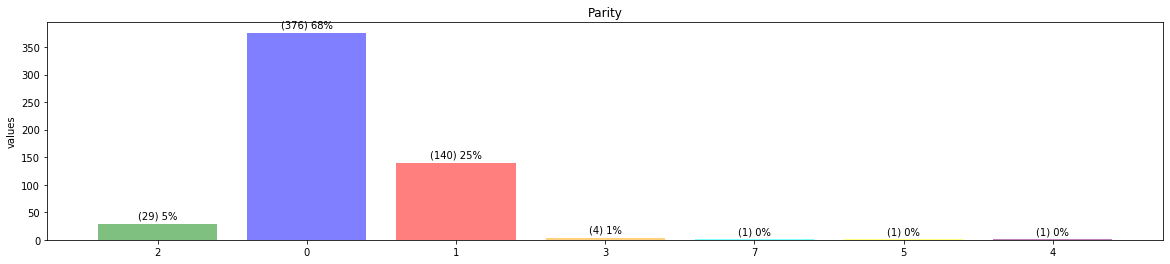

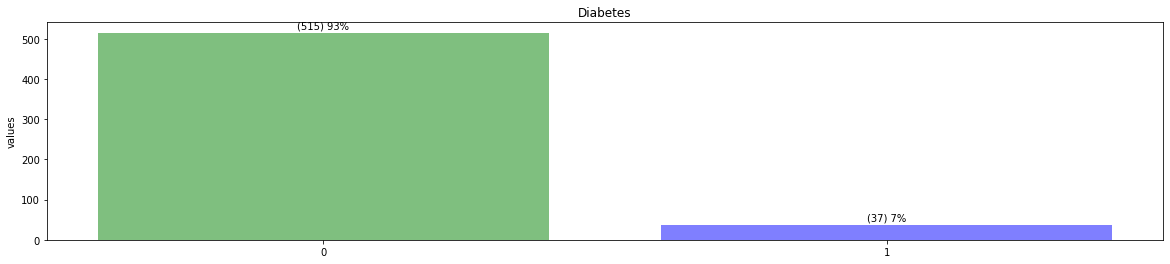

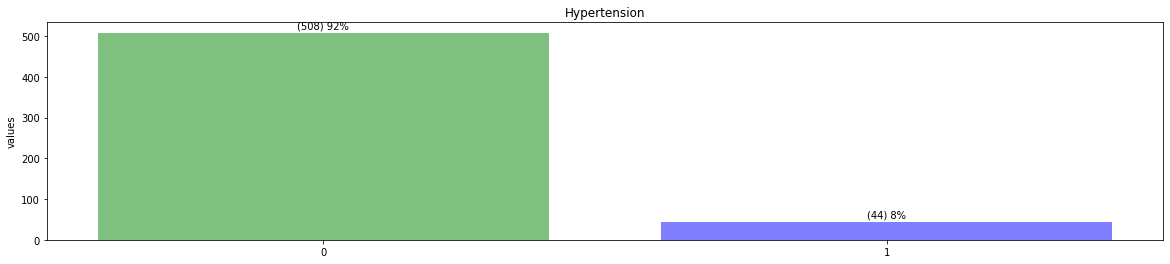

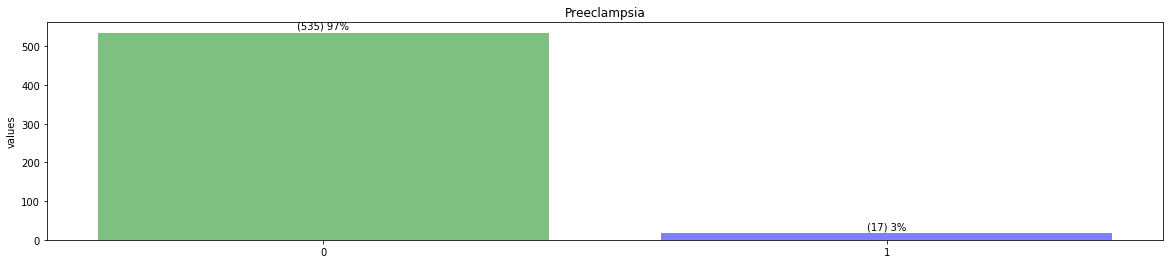

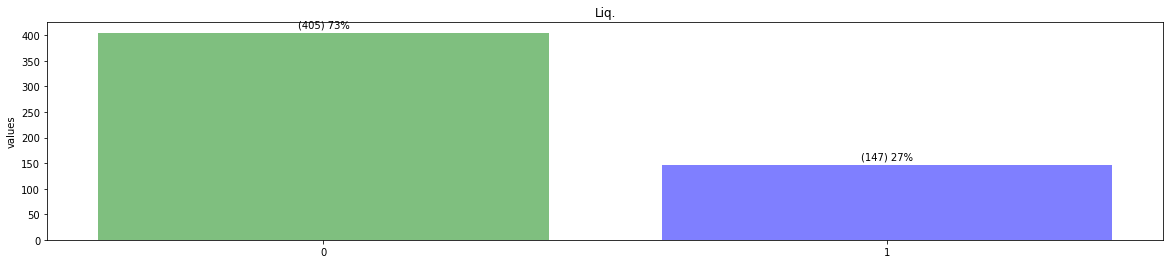

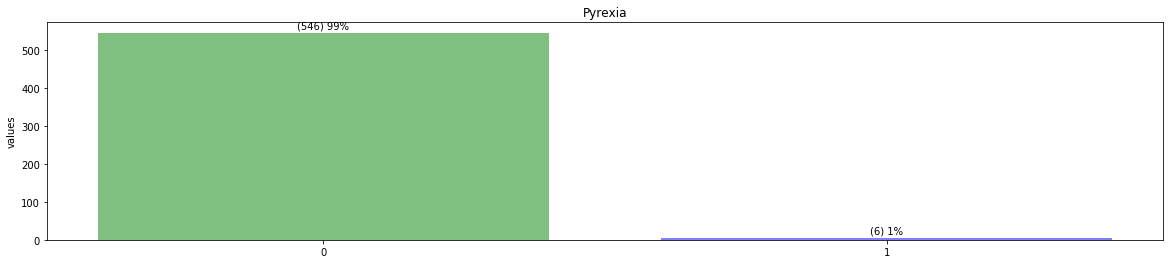

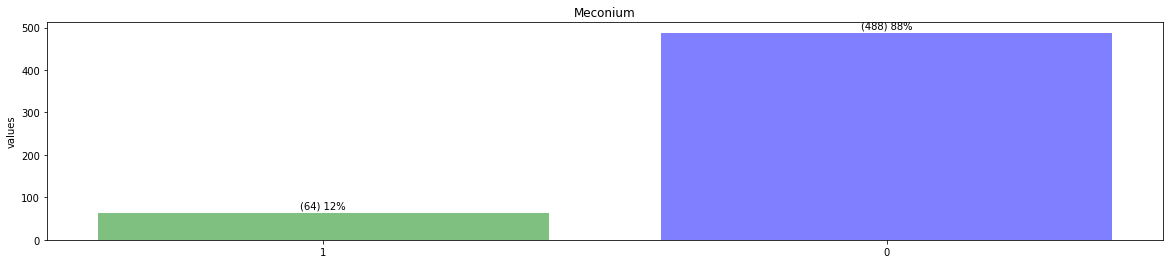

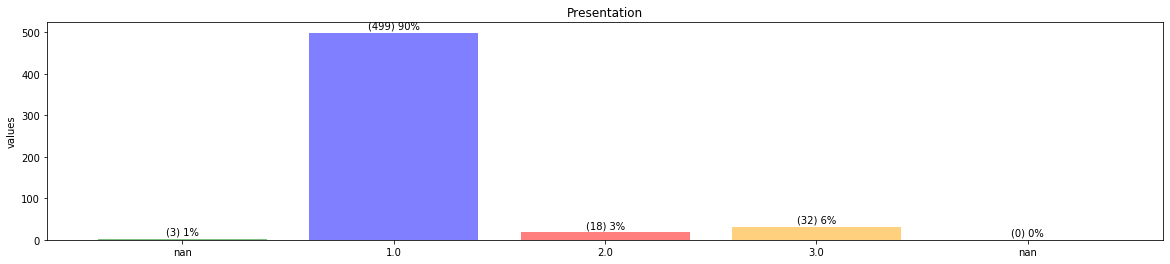

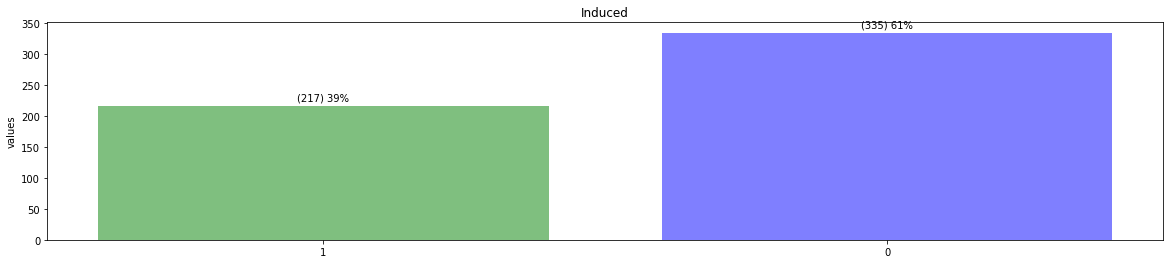

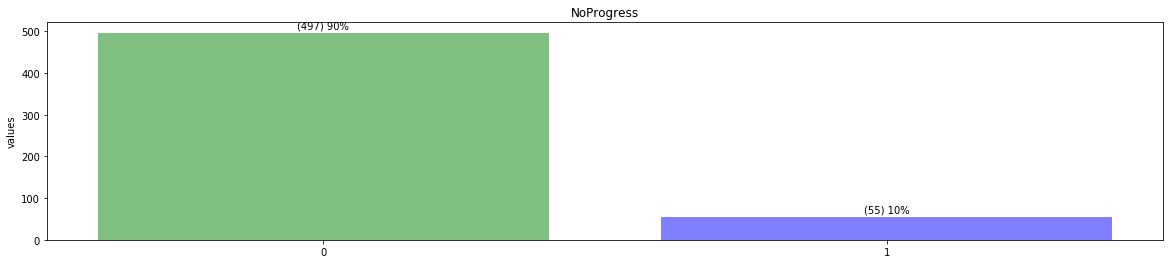

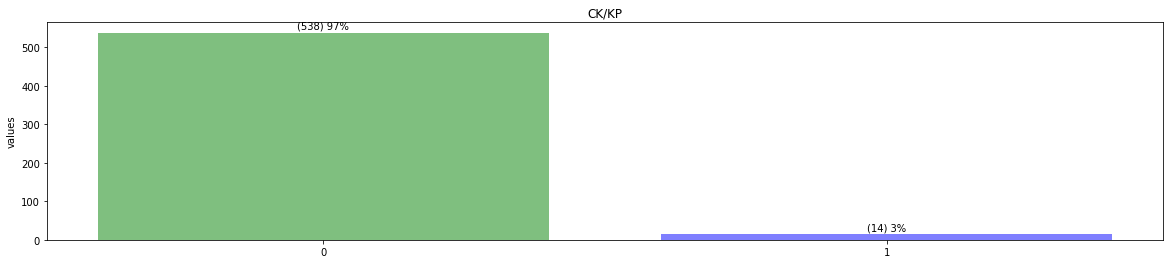

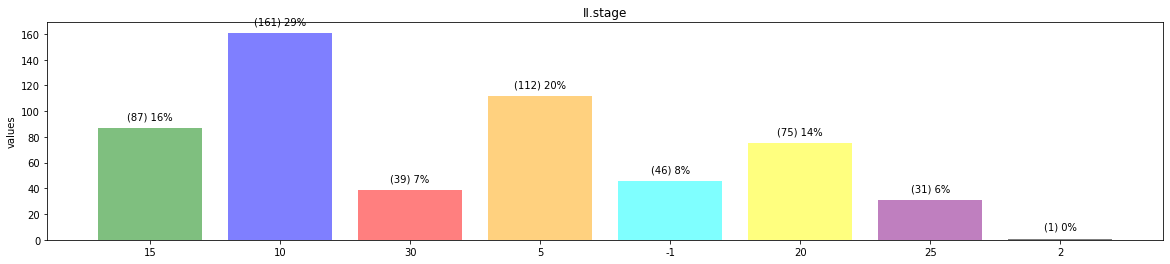

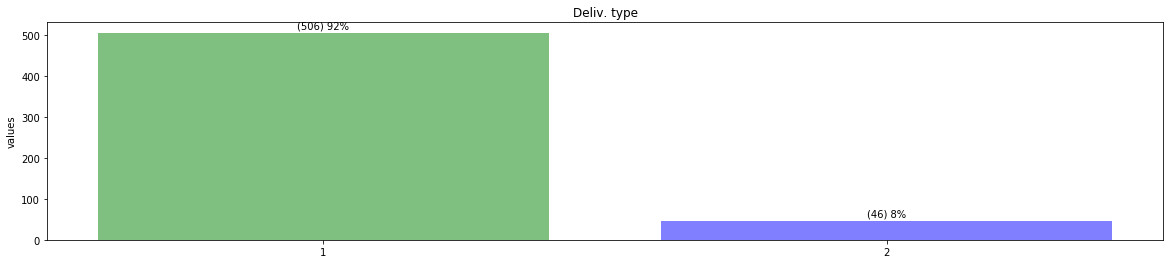

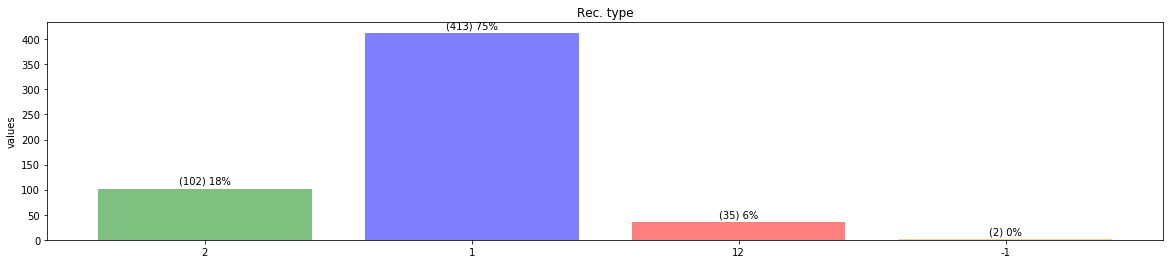

In [8]:
unique_values = ctg_data.unique_dict
for col in list(unique_values.keys()):
    if len(list(unique_values[col].keys())) < 10:
        y_pos = np.arange(len(list(unique_values[col].keys())))
        objects = list(unique_values[col].values())

        plt.figure(figsize=(20,4))
        plt.bar(y_pos, objects, align='center', alpha=0.5, color=['g','b','r','orange','cyan','yellow','purple','black','brown','gray'])
        plt.xticks(y_pos,list(unique_values[col].keys()))
        plt.ylabel('values')
        plt.title(col)
        
        ax = plt.gca()
        rects = ax.patches
        labels = ["(%i) " % x + str(round((x*100)/sum(objects))) + "%" for x in objects]
        
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                    ha='center', va='bottom')

        plt.show()

The charts show a dataset in line with what we expect normally with a skew towards a normal pregnancy/delivery. Some of the values must be re-evaluated in the light of a more accurate description of the features marked in yellow at the very beginning of this document.

Now we can get rid of the NaN values adopting the strategy number <mark>1</mark> in the list above replacing them with the mean value for the correspondent column.

In [9]:
ctg_data.convert_nan_values()
ctg_data.floats_to_integers()
ctg_data.optimize_datatypes()

100%|██████████| 6/6 [00:00<00:00, 132.34it/s]


In [10]:
ctg_data.df.head()

,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight(g),Sex,Age,...,Presentation,Induced,I.stage,NoProgress,CK/KP,II.stage,Deliv. type,dbID,Rec. type,Pos. II.st.
1220,7.30,3.52,6.0,-4.7,9,10,42,3100,2,34,...,1,1,165,0,0,15,1,3056,2,14400
1234,7.29,2.50,6.5,-4.2,8,9,41,3200,1,29,...,1,0,135,0,0,10,1,5619,1,14400
1208,7.23,5.84,6.6,-7.4,9,9,40,3900,2,26,...,1,0,260,0,0,30,1,960,12,14400
1038,7.33,2.72,5.7,-4.0,10,10,39,2740,1,24,...,2,0,15,0,0,10,1,19468,1,14400
1004,7.30,5.19,5.5,-6.4,8,9,41,3370,1,36,...,1,1,55,0,0,10,1,237,12,14400


We can see we optimised the datatypes as well so to reduce the memory usage and speed up our computations.

In [11]:
ctg_data.df.dtypes


pH              float32
BDecf           float32
pCO2            float32
BE              float32
Apgar1             int8
Apgar5             int8
Gest. weeks        int8
Weight(g)         int16
Sex                int8
Age                int8
Gravidity          int8
Parity             int8
Diabetes           int8
Hypertension       int8
Preeclampsia       int8
Liq.               int8
Pyrexia            int8
Meconium           int8
Presentation       int8
Induced            int8
I.stage           int16
NoProgress         int8
CK/KP              int8
II.stage           int8
Deliv. type        int8
dbID              int16
Rec. type          int8
Pos. II.st.       int16
dtype: object

### Danger:
The following is a very computationally expensive process that will take the **FHR** and **UC** signal of each baby and match it with the appropriate annotations. This process will create a single dataframe with a lot of redundancy (1.3Gb). If there is a better way to combine the annotations with the signals, please let me know! :)

In [12]:
#df = pd.DataFrame()
#files = []
#for directory, subdir, files in os.walk("database/signals/"):
#    pass

#total = len(files)    
#with tqdm(total=total, position=0, leave=True) as pbar:
#    for file in files:
#        pbar.update()
#        if file[file.find("."):] == ".csv":
#            df_signal = CTG_data(file) 
#            filename = file[:file.find(".")]
#            ann = ctg_data.df.loc[ctg_data.df.index == filename]
#            for f in ann.columns:
#                feature_list = []
#                for i in range(df_signal.df.shape[0]):
#                    feature_list.append(ann[f][0]) 
#                df_signal.df[f] = feature_list
#            if df.shape[0] == 0:
#                df = df_signal.df
#            else:
#                df = pd.concat([df,df_signal.df])
#        break

#print(df.shape)
#df.head()

In [13]:
#df.to_csv("database/full.csv", index=False)

In [14]:
ctg_data.df.head()

,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight(g),Sex,Age,...,Presentation,Induced,I.stage,NoProgress,CK/KP,II.stage,Deliv. type,dbID,Rec. type,Pos. II.st.
1220,7.30,3.52,6.0,-4.7,9,10,42,3100,2,34,...,1,1,165,0,0,15,1,3056,2,14400
1234,7.29,2.50,6.5,-4.2,8,9,41,3200,1,29,...,1,0,135,0,0,10,1,5619,1,14400
1208,7.23,5.84,6.6,-7.4,9,9,40,3900,2,26,...,1,0,260,0,0,30,1,960,12,14400
1038,7.33,2.72,5.7,-4.0,10,10,39,2740,1,24,...,2,0,15,0,0,10,1,19468,1,14400
1004,7.30,5.19,5.5,-6.4,8,9,41,3370,1,36,...,1,1,55,0,0,10,1,237,12,14400


In [37]:
def get_signal_df(x):
    #df = pd.read_csv("database/signals/%s.csv" % x, index_col="seconds")
    df = CTG_data(x + ".csv").df
    return df
def get_FHR(x):
    df = CTG_data(x + ".csv").df
    return df["FHR"]
def get_UC(x):
    df = CTG_data(x + ".csv").df
    return df["UC"]
def get_signal_desc(x,feat):
    df = CTG_data(x + ".csv").df
    feat_desc = pd.DataFrame(df[feat].describe()).T
    for col in feat_desc.columns:
        feat_desc = feat_desc.rename(columns={col:feat+"_"+col})
    feat_desc.reset_index(drop=True, inplace=True)
    feat_desc.set_index(pd.Series([x]),inplace=True)
    return feat_desc


#ctg_data.df["FHR_UC"] = [get_signal_df(x) for x in tqdm(ctg_data.df.index)]
#ctg_data.df["FHR"] = [get_FHR(x) for x in tqdm(ctg_data.df.index)]
#ctg_data.df["UC"] = [get_UC(x) for x in tqdm(ctg_data.df.index)]
df_FHR = pd.DataFrame()
df_UC = pd.DataFrame()
for i in tqdm(ctg_data.df.index):
    df_FHR = pd.concat([df_FHR,get_signal_desc(i,"FHR")])
    df_UC = pd.concat([df_UC,get_signal_desc(i,"UC")])
    
df_signals = pd.concat([df_FHR,df_UC],axis=1,sort=False)
df_signals.head()

100%|██████████| 552/552 [00:36<00:00, 15.19it/s]


,FHR_count,FHR_mean,FHR_std,FHR_min,FHR_25%,FHR_50%,FHR_75%,FHR_max,UC_count,UC_mean,UC_std,UC_min,UC_25%,UC_50%,UC_75%,UC_max
1220,18000.0,-56.890056,80.440605,-128.0,-112.00,-103.00,0.00,127.00,18000.0,16.480944,18.429489,0.0,1.0,11.0,25.0,100.0
1234,16800.0,115.990524,45.937656,0.0,110.25,132.75,144.50,201.50,16800.0,20.551161,15.725388,0.0,10.5,16.0,25.0,121.5
1208,21600.0,121.000519,28.417067,0.0,120.00,127.75,132.75,178.25,21600.0,19.227501,16.027731,0.0,8.0,16.0,26.5,100.0
1038,16800.0,105.559212,55.119530,0.0,102.25,129.25,136.75,239.25,16800.0,22.069643,26.415922,0.0,2.5,17.0,26.0,127.0
1004,16800.0,133.030075,26.071196,0.0,131.00,139.00,149.25,166.75,16800.0,22.084762,30.394561,0.0,0.0,6.0,37.0,100.0


In [38]:
ctg_data.df = pd.concat([ctg_data.df,df_signals],axis=1,sort=False)
ctg_data.df.head()

,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight(g),Sex,Age,...,FHR_75%,FHR_max,UC_count,UC_mean,UC_std,UC_min,UC_25%,UC_50%,UC_75%,UC_max
1220,7.30,3.52,6.0,-4.7,9,10,42,3100,2,34,...,0.00,127.00,18000.0,16.480944,18.429489,0.0,1.0,11.0,25.0,100.0
1234,7.29,2.50,6.5,-4.2,8,9,41,3200,1,29,...,144.50,201.50,16800.0,20.551161,15.725388,0.0,10.5,16.0,25.0,121.5
1208,7.23,5.84,6.6,-7.4,9,9,40,3900,2,26,...,132.75,178.25,21600.0,19.227501,16.027731,0.0,8.0,16.0,26.5,100.0
1038,7.33,2.72,5.7,-4.0,10,10,39,2740,1,24,...,136.75,239.25,16800.0,22.069643,26.415922,0.0,2.5,17.0,26.0,127.0
1004,7.30,5.19,5.5,-6.4,8,9,41,3370,1,36,...,149.25,166.75,16800.0,22.084762,30.394561,0.0,0.0,6.0,37.0,100.0


Heatmap of correlation of the Apgar1 and 5 on the other features


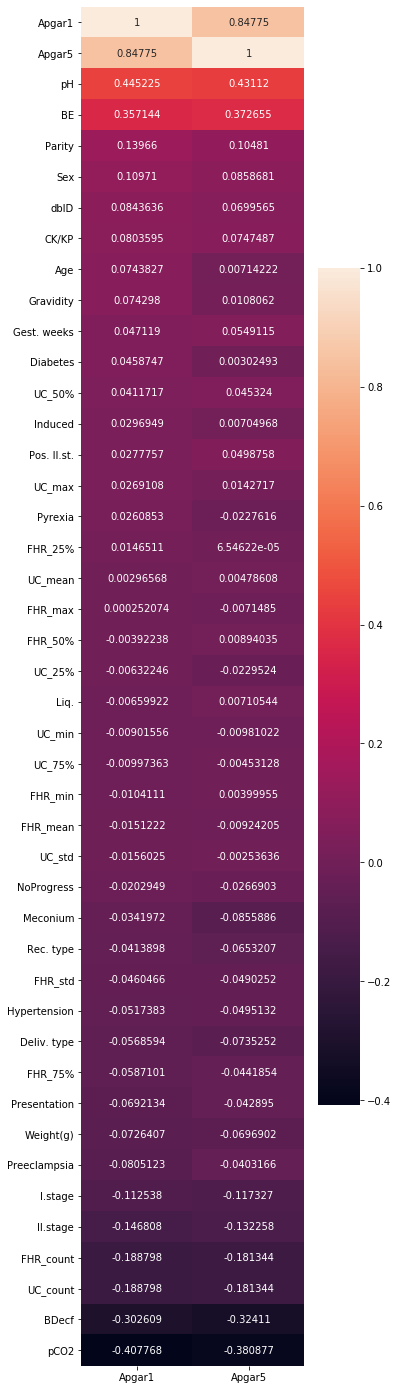

In [39]:
riskCorr = pd.DataFrame(ctg_data.df.corr()['Apgar1'])
riskCorr = riskCorr.sort_values('Apgar1',ascending=False)
riskCorr2 = pd.DataFrame(ctg_data.df.corr()['Apgar5'])
riskCorr2 = riskCorr2.sort_values('Apgar5',ascending=False)
corr_df = pd.DataFrame()
corr_df["Apgar1"] = riskCorr['Apgar1']
corr_df["Apgar5"] = riskCorr2['Apgar5']
plt.figure(figsize=(5, 25))
sns.heatmap(corr_df, annot=True, fmt="g")
print('Heatmap of correlation of the Apgar1 and 5 on the other features')